In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import lifetimes

### Importing Raw Data

In [2]:
# Read in CD data
cd_df = pd.read_csv('../data/cdnow_sample.csv')
cd_df['order_date'] = pd.to_datetime(cd_df['order_date'])

# Get a glimpse of the data!
print('Column data types: \n', cd_df.dtypes)
cd_df.head()

Column data types: 
 customer_id             int64
order_date     datetime64[ns]
order_qty               int64
order_price           float64
dtype: object


,customer_id,order_date,order_qty,order_price
0,1,1997-01-01,2,29.33
1,1,1997-01-18,2,29.73
2,1,1997-08-02,1,14.96
3,1,1997-12-12,2,26.48
4,2,1997-01-01,3,63.34


### Exploratory Data Analysis

In [3]:
# Notice, data only includes CD orders between Jan 1997-July 1998
print(cd_df['order_date'].describe())

# Convert order date to month/year to prepare for cohort analysis
cd_df['order_date'] = cd_df['order_date'].dt.to_period('M')

count                    6919
unique                    545
top       1997-03-24 00:00:00
freq                       60
first     1997-01-01 00:00:00
last      1998-06-30 00:00:00
Name: order_date, dtype: object


In [4]:
# Distribution of customers' orders
cd_df.groupby('customer_id')['order_qty'].sum().describe()

count    2357.000000
mean        6.991515
std        13.905603
min         1.000000
25%         1.000000
50%         3.000000
75%         7.000000
max       378.000000
Name: order_qty, dtype: float64

### Illustrating Cohort Analysis

In [5]:
# Let's track the number of customers who continue to
# purchase each month after their acquisition date
acq_df = cd_df.copy()
acq_df = acq_df[['customer_id', 'order_date']].drop_duplicates()

In [6]:
# Get date customer was acquired
acq_df['acq_cohort'] = acq_df.groupby('customer_id')['order_date'].transform('min')

# Get number of customers in each cohort
acq_df['cohort_size'] = acq_df.groupby('acq_cohort')['customer_id'].transform('nunique')

# Get number of customers in each cohort who purchased in a given month
acq_df['cohort_monthly_purchasers'] = acq_df.groupby(['acq_cohort', 'order_date'])['customer_id'].transform('nunique')

# Get % of customers who purchase each month relative to how many purchased
# during month of acquisition
acq_df['retention_rate'] = acq_df['cohort_monthly_purchasers'] / acq_df['cohort_size']

# Get a glimpse of the data!
acq_df.head()

,customer_id,order_date,acq_cohort,cohort_size,cohort_monthly_purchasers,retention_rate
0,1,1997-01,1997-01,781,781,1.000000
2,1,1997-08,1997-01,781,53,0.067862
3,1,1997-12,1997-01,781,59,0.075544
4,2,1997-01,1997-01,781,781,1.000000
6,3,1997-01,1997-01,781,781,1.000000


In [7]:
# Pivot data to prepare for plotting
acq_df = acq_df[['acq_cohort', 'order_date', 'retention_rate']].drop_duplicates()
acq_df = acq_df.pivot(index='order_date', columns='acq_cohort', values='retention_rate')
acq_df = acq_df.reset_index()
acq_df.columns = ['order_date', 'retention_jan_acq', 'retention_feb_acq', 'retention_mar_acq']

# Get a glimpse of the data!
acq_df.head()

,order_date,retention_jan_acq,retention_feb_acq,retention_mar_acq
0,1997-01,1.000000,NaN,NaN
1,1997-02,0.158771,1.000000,NaN
2,1997-03,0.121639,0.156359,1.000000
3,1997-04,0.089629,0.128355,0.121001
4,1997-05,0.083227,0.087515,0.116829


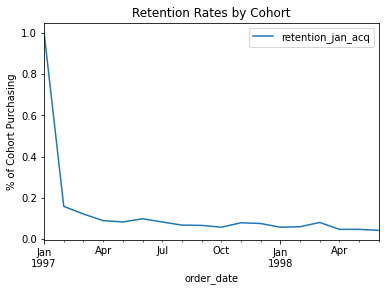

In [8]:
# Prepare retention rate plot
fig, ax = plt.subplots()
ax.set_title('Retention Rates by Cohort')
ax.set_ylabel('% of Cohort Purchasing')

# Plot overall retention rates
acq_df.plot.line(x='order_date', y='retention_jan_acq', ax=ax)
plt.show()

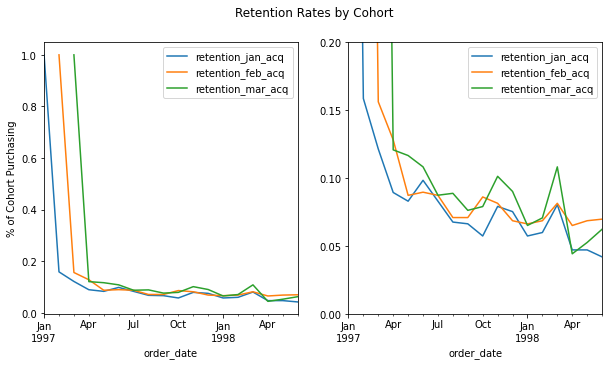

In [9]:
# Prepare retention rates plots
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
plt.suptitle('Retention Rates by Cohort')
ax1.set_ylabel('% of Cohort Purchasing')
ax2.set_ylim(0, 0.2)
ax2.set_yticks(np.arange(0, 0.21, 0.05))

# Plot retention rates for each cohort
acq_df.plot.line(x='order_date', y='retention_jan_acq', ax=ax1)
acq_df.plot.line(x='order_date', y='retention_feb_acq', ax=ax1)
acq_df.plot.line(x='order_date', y='retention_mar_acq', ax=ax1)
acq_df.plot.line(x='order_date', y='retention_jan_acq', ax=ax2)
acq_df.plot.line(x='order_date', y='retention_feb_acq', ax=ax2)
acq_df.plot.line(x='order_date', y='retention_mar_acq', ax=ax2)
plt.show()

<AxesSubplot:title={'center':'Heatmap of Cohort-Level Retention Rates'}, xlabel='order_date'>

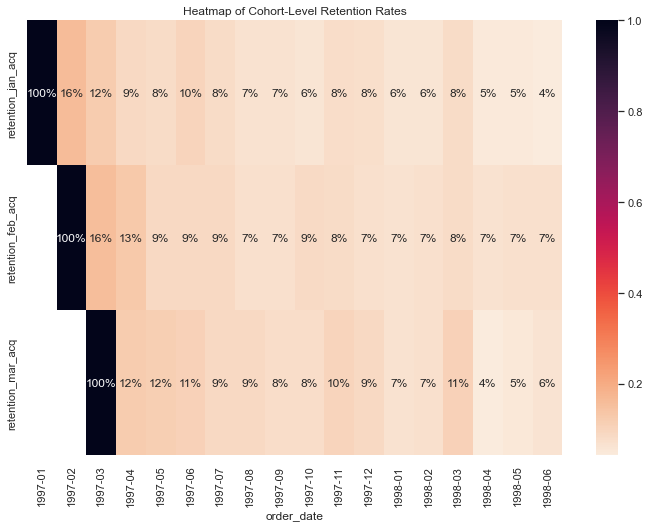

In [10]:
# Prepare heatmap of cohort-level retention rates
sns.set(style='white')
plt.figure(figsize=(12, 8))
plt.title('Heatmap of Cohort-Level Retention Rates')

# Plot heatmap of retention rates by month for each cohort
sns.heatmap(
    acq_df.set_index('order_date').T,
    mask=acq_df.set_index('order_date').T.isnull(),
    annot=True,
    fmt='.0%',
    cmap=sns.cm.rocket_r)

### Overview

##### What is Cohort Analysis?

When motivating the value of estimating the CLV of a company's customers, [Fader suggests evaluating the CLV estimates of particular cohorts of customers](https://www.youtube.com/watch?v=guj2gVEEx4s&ab_channel=FirstMarkCapital), rather than evaluating CLV estimates of individual customers. In particular, he recommends evaluating the accuracy of CLV estimates on cohorts of customers who have been acquired at a similar time (e.g. same month, year, etc.). To help illustrate the usefulness of focusing on certain cohorts and evaluating cohorts altogether, we'll introduce a basic, yet relevant, analysis of  cohorts of customers who've ordered CDs from an old company called CDnow. 

Specifically, we'll take a look at the purchasing behavior of their customers based on the date they were acquired. It'a common for cohorts to be based on a customer's acquisition date, but their acquisition can refer to purchasing acquisition, engagement acquisition, etc. Which acquisition dependent really depends on a company's business model.

As an example, Hulu might refer to a customer's acquisition as the date on which a customer signs up for their subscription service. On the other hand, Walmart may refer to a customer's acquisition as the date on which a customer purchases from their stores or online. However, Facebook is a free service relying on customer engagement, so they'd likely be more interested in when the customer first signed up, or maybe engaged by liking a photo, etc.

In other words, when deciding what event should be considered for a customer's acquisition of a paricular event, it's important to consider the the company's business model, especially when putting together a cohort analysis.

##### Reasons for conducting Cohort Analysis

Over time, a company experiences many changes to their business, such as their brand image, product features, stores, and many other factors. As a result, it becomes crucial for a company to understand their customers. As Fader has stated many times, there isn't an *average customer* and companies should start thinking that no two customers are alike. Therefore, understanding how similar customers evolve over time should be mission critical for any company.

For additional examples of cohort analysis, refer to [this great blog post](http://www.gregreda.com/2015/08/23/cohort-analysis-with-python/) outlining examples of cohort analysis on user-engagement and customer-purchase data.